In [1]:
%load_ext autoreload
%autoreload 2

# Hubble Space Telescope (HST) simple model

## PAOS

In [1]:
from paos.core.parseConfig import parse_config
from paos.core.run import run
from paos.core.plot import simple_plot
import matplotlib.pyplot as plt

In [2]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../lens data/Hubble_simple.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
parameters['zoom'] = 2
retval_paos = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)

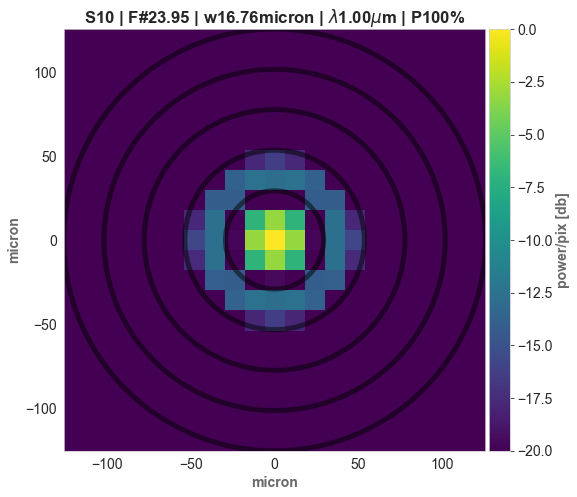

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
key = list(retval_paos.keys())[-1]  # plot at last optical surface
item = retval_paos[key]
simple_plot(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

## PROPER

In [5]:
import proper, time
import numpy as np
from paos.classes.abcd import ABCD

In [6]:
def hubble_simple(wavelength, gridsize, PASSVALUE=None):
    if PASSVALUE is None:
        PASSVALUE = {}
    proper.print_it = True

    start_time = time.time()

    # Define entrance aperture diameter and other quantities
    diam = 2.4  # telescope diameter in meters
    fl_pri = 5.52085  # HST primary focal length (m)
    d_pri_sec = 4.907028205  # primary to secondary separation (m)
    fl_sec = -0.6790325  # HST secondary focal length (m)
    d_sec_to_focus = 6.3919974  # nominal distance from secondary to focus
    beam_ratio = 0.5  # initial beam width/grid width

    # Define the wavefront
    wfo = proper.prop_begin(diam, wavelength, gridsize, beam_ratio)
    proper.prop_set_antialiasing(nsub=101)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam / 2)  # HST aperture (primary mirror)
    proper.prop_circular_obscuration(wfo, 0.396)  # secondary mirror obscuration
    proper.prop_rectangular_obscuration(wfo, 0.0264, 2.5)  # secondary vane (vertical)
    proper.prop_rectangular_obscuration(wfo, 2.5, 0.0264)  # secondary vane (horizontal)
    proper.prop_circular_obscuration(wfo, 0.078, -0.9066, -0.5538)  # primary mirror pad 1
    proper.prop_circular_obscuration(wfo, 0.078, 0., 1.0705)  # primary mirror pad 2
    proper.prop_circular_obscuration(wfo, 0.078, 0.9127, -0.5477)  # primary mirror pad 3

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    PASSVALUE[0] = push_results(wfo, init=True)
    proper.prop_lens(wfo, fl_pri, "primary")  # primary mirror
    PASSVALUE[0].update(push_results(wfo))

    # Propagate the wavefront
    proper.prop_propagate(wfo, d_pri_sec, "secondary")

    PASSVALUE[1] = push_results(wfo)
    proper.prop_lens(wfo, fl_sec, "secondary")
    PASSVALUE[1].update(push_results(wfo))

    PASSVALUE[2] = push_results(wfo)
    proper.prop_propagate(wfo, d_sec_to_focus, "HST focus", TO_PLANE=False)
    PASSVALUE[2].update(push_results(wfo))

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    end_time = time.time()

    if proper.print_it:
        print("Total elapsed time (seconds) = %8.4f" % (end_time - start_time))

    return PASSVALUE

In [7]:
def extent(wfarr, dx, dy):
    return (-wfarr.shape[1] // 2 * dx, (wfarr.shape[1] // 2 - 1) * dx,
            -wfarr.shape[0] // 2 * dy, (wfarr.shape[0] // 2 - 1) * dy)


def push_results(wfo, init=False):
    if init:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'fratio': fratio if fratio < 1e9 else np.inf}
    else:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'amplitude': proper.prop_get_amplitude(wfo),
                  'wz': proper.prop_get_beamradius(wfo),
                  'distancetofocus': proper.prop_get_distancetofocus(wfo),
                  'phase': -proper.prop_get_phase(wfo),  # phase angles in proper are defined in the opposite sense
                  'dx': proper.prop_get_sampling(wfo),
                  'dy': proper.prop_get_sampling(wfo),
                  'wfo': proper.prop_get_wavefront(wfo),
                  'wl': proper.prop_get_wavelength(wfo),
                  'aperture': None,
                  'fratio': fratio if fratio < 1e9 else np.inf
                  }
        retval['extent'] = extent(retval['wfo'], retval['dx'], retval['dy'])
    return retval

In [8]:
retval_proper = hubble_simple(1e-6, 1024, PASSVALUE={})

Applying lens at primary
Propagating to secondary
Applying lens at secondary
Propagating to HST focus
Total elapsed time (seconds) =   3.0267


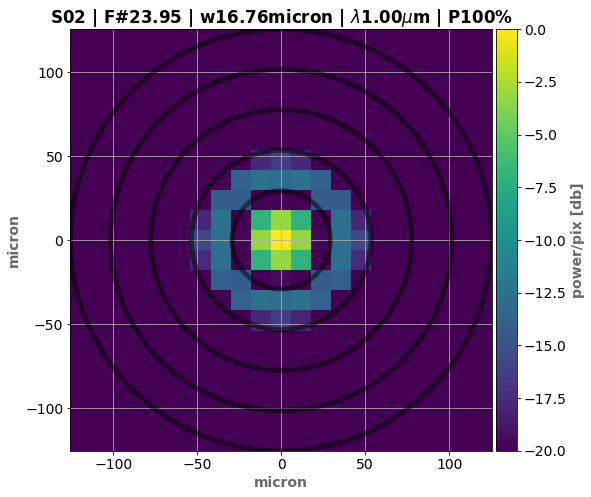

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
key = list(retval_proper.keys())[-1]  # plot at last optical surface
item = retval_proper[key]
item['aperture'] = None
item['ABCDt'] = ABCD
simple_plot(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

## Validation

In [10]:
from copy import deepcopy

retval_proper_dc = deepcopy(retval_proper)

In [11]:
proper_key = list(retval_proper_dc.keys())[-1]  # plot at last optical surface
proper_item = retval_proper_dc[proper_key]
paos_key = list(retval_paos.keys())[-1]  # plot at last optical surface
paos_item = retval_paos[paos_key]

In [12]:
proper_phase = proper_item['phase']
paos_phase = paos_item['phase']

proper_amplitude = proper_item['amplitude']
paos_amplitude = paos_item['amplitude']

proper_psf = proper_amplitude**2
paos_psf = paos_amplitude**2

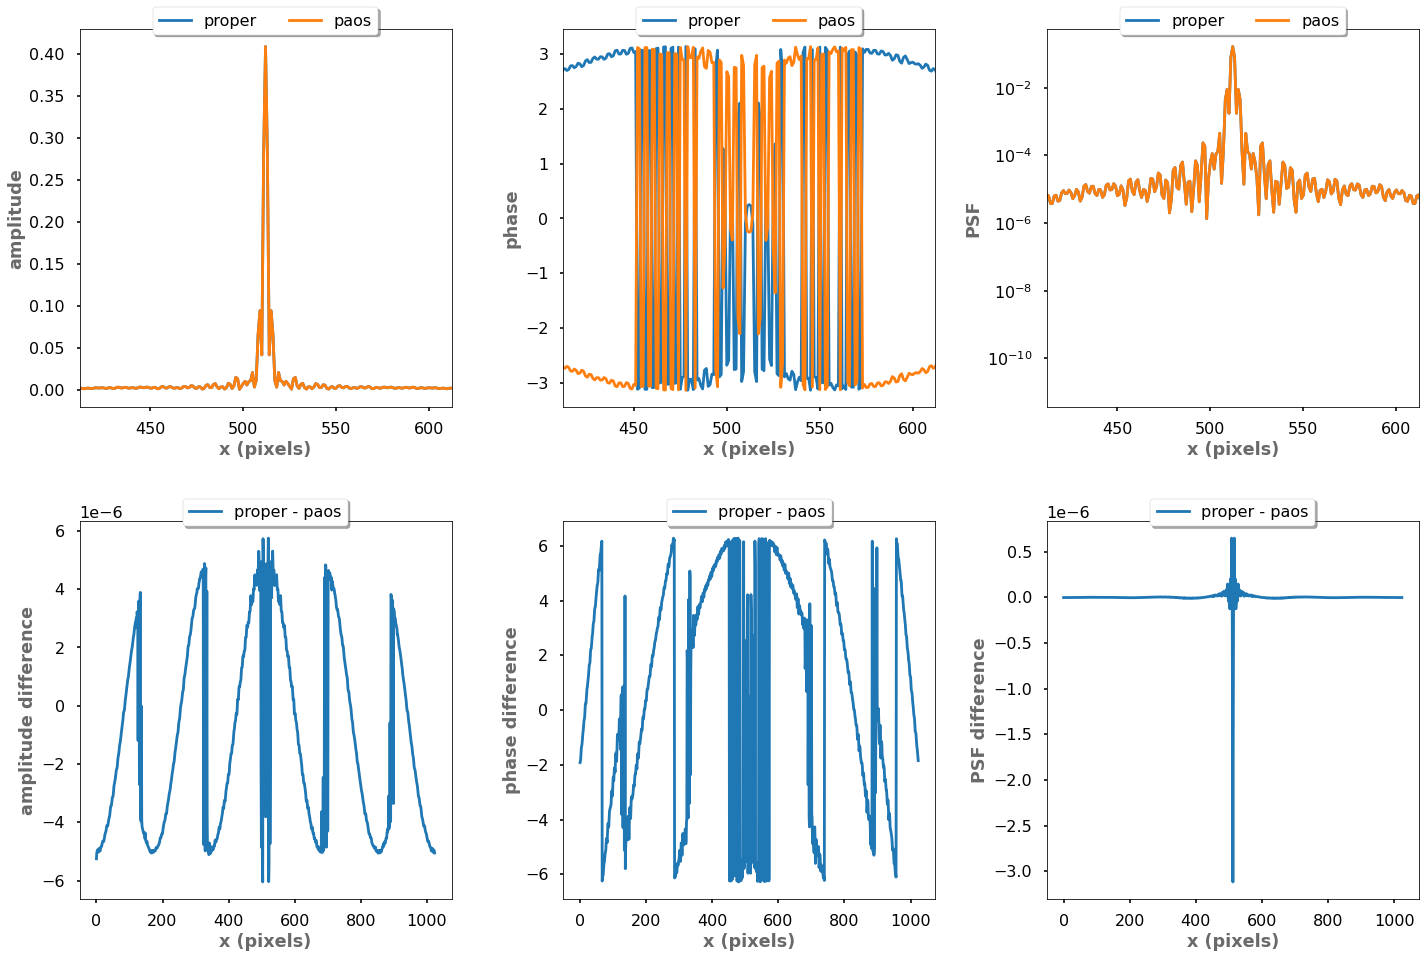

In [13]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax = ax.flatten()
ax[0].plot(proper_amplitude[proper_amplitude.shape[0] // 2, :], label='proper')
ax[0].plot(paos_amplitude[paos_amplitude.shape[0] // 2, :], label='paos')
ax[0].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# Put the legend just above the plot
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
          ncol=3, fancybox=True, shadow=True)
ax[0].set_xlabel('x (pixels)')
ax[0].set_ylabel('amplitude')

ax[1].plot(proper_phase[proper_phase.shape[0] // 2, :], label='proper')
ax[1].plot(paos_phase[paos_phase.shape[0] // 2, :], label='paos')
ax[1].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[1].set_xlabel('x (pixels)')
ax[1].set_ylabel('phase')

ax[2].semilogy(proper_psf[proper_psf.shape[0] // 2, :], label='proper')
ax[2].semilogy(paos_psf[paos_psf.shape[0] // 2, :], label='paos')
ax[2].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[2].set_xlabel('x (pixels)')
ax[2].set_ylabel('PSF')

ax[3].plot(proper_amplitude[proper_amplitude.shape[0] // 2, :] - paos_amplitude[paos_amplitude.shape[0] // 2, :], label='proper - paos')
# ax[3].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[3].set_xlabel('x (pixels)')
ax[3].set_ylabel('amplitude difference')

ax[4].plot(proper_phase[proper_phase.shape[0] // 2, :] - paos_phase[paos_phase.shape[0] // 2, :], label='proper - paos')
# ax[4].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[4].set_xlabel('x (pixels)')
ax[4].set_ylabel('phase difference')

ax[5].plot(proper_psf[proper_psf.shape[0] // 2, :] - paos_psf[paos_psf.shape[0] // 2, :], label='proper - paos')
# ax[5].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[5].set_xlabel('x (pixels)')
ax[5].set_ylabel('PSF difference')

plt.show()

# Super simple model

## PAOS

In [14]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../lens data/template.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
retval_paos = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)

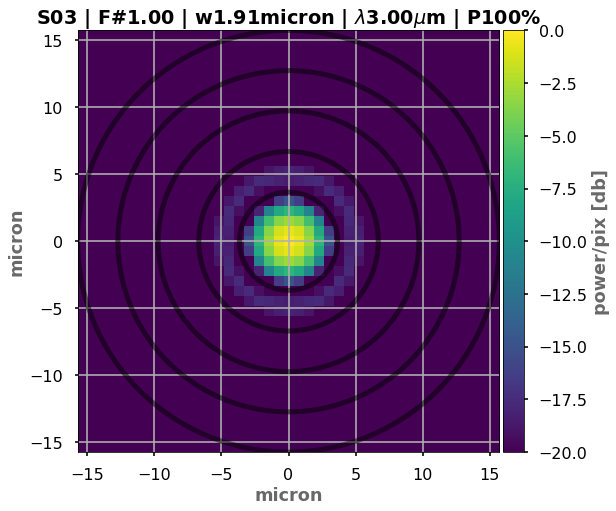

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
key = list(retval_paos.keys())[-1]  # plot at last optical surface
item = retval_paos[key]
simple_plot(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

## Proper

In [16]:
def template(wl, gridsize, PASSVALUE=None):
    if PASSVALUE is None:
        PASSVALUE = {}
    proper.print_it = True

    start_time = time.time()

    # Define entrance aperture diameter and other quantities
    diam = 1.0  # telescope diameter in meters
    fl_pri = 1.0  # primary focal length (m)
    d_pri_to_focus = 1.0  # distance from primary to focus
    beam_ratio = 0.25  # initial beam width/grid width

    # Define the wavefront
    wfo = proper.prop_begin(diam, wl, gridsize, beam_ratio)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam / 2)  # aperture (primary mirror)

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    PASSVALUE[0] = push_results(wfo, init=True)
    proper.prop_lens(wfo, fl_pri, "primary")  # primary mirror
    PASSVALUE[0].update(push_results(wfo))

    PASSVALUE[1] = push_results(wfo)
    proper.prop_propagate(wfo, d_pri_to_focus, "focus", TO_PLANE=False)
    PASSVALUE[1].update(push_results(wfo))

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    end_time = time.time()

    if proper.print_it:
        print("Total elapsed time (seconds) = %8.4f" % (end_time - start_time))

    return PASSVALUE

In [17]:
# def push_results(wfo):
#     fratio = proper.prop_get_fratio(wfo)
#     retval = {'amplitude': proper.prop_get_amplitude(wfo),
#               'wz': proper.prop_get_beamradius(wfo),
#               'distancetofocus': proper.prop_get_distancetofocus(wfo),
#               'phase': proper.prop_get_phase(wfo),
#               'dx': proper.prop_get_sampling(wfo),
#               'dy': proper.prop_get_sampling(wfo),
#               'wfo': proper.prop_get_wavefront(wfo),
#               }
#     return retval
#
# def template(wl, gridsize, PASSVALUE):
#     # Define entrance aperture diameter and other quantities
#     diam = 1.0  # telescope diameter in meters
#     fl_pri = 1.0  # primary focal length (m)
#     d_pri_to_focus = 1.0  # distance from primary to focus
#     beam_ratio = 0.25  # initial beam width/grid width
#     # Define the wavefront
#     wfo = proper.prop_begin(diam, wl, gridsize, beam_ratio)
#     # Define a circular aperture
#     proper.prop_circular_aperture(wfo, diam / 2)  # aperture (primary mirror)
#     # Define entrance
#     proper.prop_define_entrance(wfo)
#     # Define a lens
#     PASSVALUE[0] = push_results(wfo, init=True)
#     proper.prop_lens(wfo, fl_pri, "primary")  # primary mirror
#     PASSVALUE[0].update(push_results(wfo))
#     PASSVALUE[1] = push_results(wfo)
#     proper.prop_propagate(wfo, d_pri_to_focus, "focus", TO_PLANE=False)
#     PASSVALUE[1].update(push_results(wfo))
#     # End
#     (wfo, sampling) = proper.prop_end(wfo)
#     return PASSVALUE

In [18]:
retval_proper = template(wl=3e-6, gridsize=1024, PASSVALUE={})

Applying lens at primary
Propagating to focus
Total elapsed time (seconds) =   0.8139


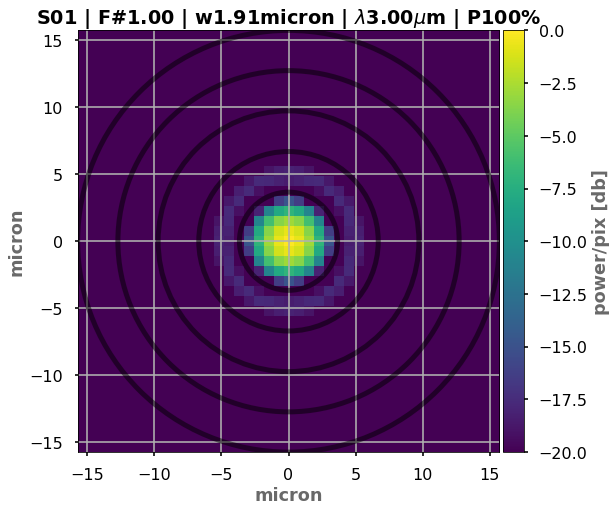

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
key = list(retval_proper.keys())[-1]  # plot at last optical surface
item = retval_proper[key]
item['aperture'] = None
item['ABCDt'] = ABCD
simple_plot(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

In [20]:
retval_proper_dc = deepcopy(retval_proper)
proper_key = list(retval_proper_dc.keys())[-1]  # plot at last optical surface
proper_item = retval_proper_dc[proper_key]
paos_key = list(retval_paos.keys())[-1]  # plot at last optical surface
paos_item = retval_paos[paos_key]
proper_phase = proper_item['phase']
paos_phase = paos_item['phase']

proper_amplitude = proper_item['amplitude']
paos_amplitude = paos_item['amplitude']

proper_psf = proper_amplitude ** 2
paos_psf = paos_amplitude ** 2

In [23]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 24 / 1.618))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle('Comparison of PROPER and PAOS', fontsize=24)

ax = ax.flatten()
ax[0].plot(proper_amplitude[proper_amplitude.shape[0] // 2, :], label='PROPER')
ax[0].plot(paos_amplitude[paos_amplitude.shape[0] // 2, :], label='PAOS')
ax[0].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# Put the legend just above the plot
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[0].set_xlabel('x (pixels)')
ax[0].set_ylabel('Amplitude')

ax[1].plot(proper_phase[proper_phase.shape[0] // 2, :], label='PROPER')
ax[1].plot(paos_phase[paos_phase.shape[0] // 2, :], label='PAOS')
ax[1].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[1].set_xlabel('x (pixels)')
ax[1].set_ylabel('Phase')

ax[2].semilogy(proper_psf[proper_psf.shape[0] // 2, :], label='PROPER')
ax[2].semilogy(paos_psf[paos_psf.shape[0] // 2, :], label='PAOS')
# ax[2].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[2].set_xlabel('x (pixels)')
ax[2].set_ylabel('PSF')

ax[3].plot(proper_amplitude[proper_amplitude.shape[0] // 2, :] - paos_amplitude[paos_amplitude.shape[0] // 2, :], label='PROPER - PAOS')
# ax[3].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[3].set_xlabel('x (pixels)')
ax[3].set_ylabel('Amplitude difference')


ax[4].plot(proper_phase[proper_phase.shape[0] // 2, :] - paos_phase[paos_phase.shape[0] // 2, :], label='PROPER - PAOS')
# ax[4].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# Enforce scientific notation
ax[4].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[4].set_xlabel('x (pixels)')
ax[4].set_ylabel('Phase difference')

ax[5].plot(proper_psf[proper_psf.shape[0] // 2, :] - paos_psf[paos_psf.shape[0] // 2, :], label='PROPER - PAOS')
# ax[5].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[5].set_xlabel('x (pixels)')
ax[5].set_ylabel('PSF difference')

plt.savefig('figures/compare_proper_paos.pdf', dpi=300, bbox_inches='tight')
# do not show the plot
plt.close()

In [22]:
# # Do the same for the y slice
#
# fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
#
# ax = ax.flatten()
# ax[0].plot(proper_amplitude[:, proper_amplitude.shape[1] // 2], label='PROPER')
# ax[0].plot(paos_amplitude[:, paos_amplitude.shape[1] // 2], label='PAOS')
# ax[0].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# # Put the legend just above the plot
# ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
#              ncol=3, fancybox=True, shadow=True)
# ax[0].set_xlabel('y (pixels)')
# ax[0].set_ylabel('amplitude')
#
# ax[1].plot(proper_phase[:, proper_phase.shape[1] // 2], label='PROPER')
# ax[1].plot(paos_phase[:, paos_phase.shape[1] // 2], label='PAOS')
# ax[1].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
#              ncol=3, fancybox=True, shadow=True)
# ax[1].set_xlabel('y (pixels)')
# ax[1].set_ylabel('phase')
#
# ax[2].semilogy(proper_psf[:, proper_psf.shape[1] // 2], label='PROPER')
# ax[2].semilogy(paos_psf[:, paos_psf.shape[1] // 2], label='PAOS')
# ax[2].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
#              ncol=3, fancybox=True, shadow=True)
# ax[2].set_xlabel('y (pixels)')
# ax[2].set_ylabel('PSF')
#
# ax[3].plot(proper_amplitude[:, proper_amplitude.shape[0] // 2] - paos_amplitude[:, paos_amplitude.shape[0] // 2], label='PROPER - PAOS')
# # ax[3].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# ax[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
#              ncol=3, fancybox=True, shadow=True)
# ax[3].set_xlabel('x (pixels)')
# ax[3].set_ylabel('amplitude difference')
#
# ax[4].plot(proper_phase[:, proper_phase.shape[0] // 2] - paos_phase[:, paos_phase.shape[0] // 2], label='PROPER - PAOS')
# # ax[4].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# # Enforce scientific notation
# ax[4].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
#              ncol=3, fancybox=True, shadow=True)
# ax[4].set_xlabel('x (pixels)')
# ax[4].set_ylabel('phase difference')
#
# ax[5].plot(proper_psf[:, proper_psf.shape[0] // 2] - paos_psf[:, paos_psf.shape[0] // 2], label='PROPER - PAOS')
# # ax[5].set_xlim(1024 // 2 - 100, 1024 // 2 + 100)
# ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
#              ncol=3, fancybox=True, shadow=True)
# ax[5].set_xlabel('x (pixels)')
# ax[5].set_ylabel('PSF difference')
#
# plt.show()
